In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import torch
import skimage
import numpy as np
from torch import nn
from torchinfo import summary
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import BatchNorm2d, Softmax2d
from torchvision.models.resnet import ResNet
from torchvision.models.resnet import resnet50, resnet101

from datasets import CUB200
from nets import IndividualLandmarkNet, IndividualLandmarkNetModified, PartCEMTV, PartCEM
from datasets import PartImageNetDataset, CUBDataset, CelebA

In [15]:
resnet = resnet101()
net = PartCEM(resnet, 8, num_classes=200)
state_dict = torch.load('cub/cub_8parts_rebuild.pt', map_location='cpu')
net.load_state_dict(state_dict)

AttributeError: 'ResNet' object has no attribute 'startswith'

In [ ]:
data_path = os.path.join('datasets', 'cub', 'CUB_200_2011')
dataset_train = CUBDataset(data_path, split=1.0, mode='train', image_size=448)
dataset_val = CUBDataset(data_path, mode='test', train_samples=dataset_train.trainsamples, image_size=448)
val_loader = DataLoader(dataset=dataset_val, batch_size=4, shuffle=True, num_workers=4)
val_loader_iter = iter(val_loader)

In [5]:
COLORS = [[0.75,0,0],[0,0.75,0],[0,0,0.75],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5],[0.75,0.25,0],[0.75,0,0.25],[0,0.75,0.25],
    [0.75,0,0],[0,0.75,0],[0,0,0.75],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5],[0.75,0.25,0],[0.75,0,0.25],[0,0.75,0.25],
    [0.75,0,0],[0,0.75,0],[0,0,0.75],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5],[0.75,0.25,0],[0.75,0,0.25],[0,0.75,0.25]]

def landmarks_to_rgb(maps):
    """
    Converts the attention maps to maps of colors
    Parameters
    ----------
    maps: Tensor, [number of parts, width_map, height_map]
        The attention maps to display

    Returns
    ----------
    rgb: Tensor, [width_map, height_map, 3]
        The color maps
    """
    n_concepts, spatial, spatial = maps.shape
    rgb = np.zeros((spatial, spatial, 3))
    for m in range(n_concepts):
        for c in range(3):
            rgb[:, :, c] += maps[m, :, :] * COLORS[m % 25][c]
    return rgb

def save_maps(X: torch.Tensor, maps: torch.Tensor, epoch: int, model_name: str, device: torch.device) -> None:
    """
    Plot images, attention maps and landmark centroids.
    Parameters
    ----------
    X: Tensor, [batch_size, 3, width_im, height_im]
        Input images on which to show the attention maps
    maps: Tensor, [batch_size, number of parts, width_map, height_map]
        The attention maps to display
    epoch: int
        The current epoch
    model_name: str
        The name of the model
    device: torch.device
        The device to use

    Returns
    -------
    """
    vis_size = (256, 256)
    batch_size, n_concepts, spatial, spatial = maps.shape
    grid_x, grid_y = torch.meshgrid(torch.arange(spatial), torch.arange(spatial))
    grid_x = grid_x[None, None, ...]
    grid_y = grid_y[None, None, ...]
    map_sums = maps.sum(3).sum(2).detach() # shape: [b, n_concepts]
    maps_x = grid_x * maps
    maps_y = grid_y * maps
    loc_x = maps_x.sum(3).sum(2) / map_sums
    loc_y = maps_y.sum(3).sum(2) / map_sums

    fig, axs = plt.subplots(2, 2)
    for i, ax in enumerate(axs.reshape(-1)):
        if i < maps.shape[0]:
            landmarks = landmarks_to_rgb(maps[i, :-1, ...].numpy()) # shape: [n_concepts, w, h] -> [w, h, 3]
            print(landmarks.shape, X[i, ...].permute(1, 2, 0).numpy().shape)
            # w, h, c
            img_with_landmarks = skimage.transform.resize(landmarks, vis_size) + skimage.transform.resize(X[i, ...].permute(1, 2, 0).numpy(), vis_size)
            ax.imshow(np.clip(img_with_landmarks, a_min=0, a_max=1))
            x_coords = loc_y[i, 0:-1] * 256 / spatial
            y_coords = loc_x[i, 0:-1] * 256 / spatial
            cols = COLORS[0: n_concepts - 1]
            n = np.arange(n_concepts)
            for xi, yi, col_i, mark in zip(x_coords, y_coords, cols, n):
                ax.scatter(xi, yi, color=col_i, marker=f'${mark}$')

    # plt.savefig(f'./results_{model_name}/{epoch}_{np.random.randint(0, 10)}')
    # plt.close()

In [7]:
device = 'cpu'
net.eval()

with torch.no_grad():
    imgs, labels = next(val_loader_iter)
    _, maps, scores = net(imgs)
    scores = scores.detach()
    # Saving the attention maps
    # save_maps(imgs, maps, 0, 'cub_interpolate', device)


NameError: name 'val_loader_iter' is not defined

(28, 28, 3) (448, 448, 3)
(28, 28, 3) (448, 448, 3)
(28, 28, 3) (448, 448, 3)
(28, 28, 3) (448, 448, 3)


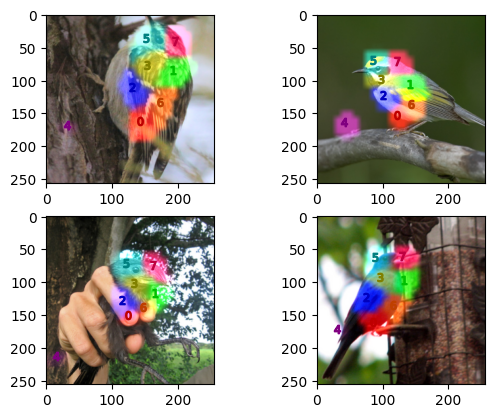

In [23]:
save_maps(imgs, maps, 0, 'cub_interpolate', 'cpu')

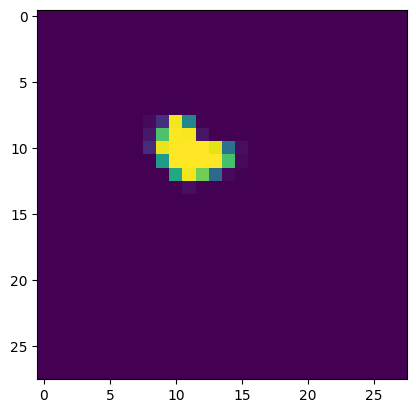

In [7]:
torch.set_printoptions(precision=3, sci_mode=False)
plt.imshow(maps[0, 2, :, :])

In [8]:
np.round(maps[0, 0, :, :].numpy(), 4)

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00,
      

In [9]:
len(COLORS)

27